<a href="https://colab.research.google.com/github/abhiiyer/ERA1/blob/main/Session-7/Model-4/ERA_Session7_Model4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Target

- Fine Tune the Transforms, set rotation to `-10deg to 10deg`
- Include StepLR rate schedule
- Optimize the learning rate and drop out value

## 2. Result

- Params: `7,416`
- Best Train Accuracy: `99.06%`
- Best Test Accuracy : `99.45%`

## 3. Analysis

- Now the learning is consistent, the validation accuracy > 99.4 for almost 5-6 EPOCHS

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download = True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 101617570.66it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29697399.81it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24517395.35it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23842964.67it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Availalbe?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True,batch_size=128,num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Availalbe? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            # nn.BatchNorm2d(8),
            # nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 4
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)

        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1,10)

        return F.log_softmax(x, dim=-1)


In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
       BatchNorm2d-5           [-1, 16, 24, 24]              32
           Dropout-6           [-1, 16, 24, 24]               0
            Conv2d-7            [-1, 8, 24, 24]             128
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 16, 10, 10]           1,152
             ReLU-10           [-1, 16, 10, 10]               0
      BatchNorm2d-11           [-1, 16, 10, 10]              32
          Dropout-12           [-1, 16, 10, 10]               0

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))


In [8]:
from torch.optim.lr_scheduler import StepLR
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.07285037636756897 Batch_id=468 Accuracy=92.31: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]



Test set: Average loss: 0.0519, Accuracy: 9842/10000 (98.42%)

EPOCH: 1


Loss=0.040449630469083786 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]



Test set: Average loss: 0.0355, Accuracy: 9894/10000 (98.94%)

EPOCH: 2


Loss=0.10507757216691971 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]



Test set: Average loss: 0.0372, Accuracy: 9882/10000 (98.82%)

EPOCH: 3


Loss=0.04980284348130226 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:19<00:00, 23.53it/s]



Test set: Average loss: 0.0283, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.08709386736154556 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:21<00:00, 21.42it/s]



Test set: Average loss: 0.0272, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Loss=0.051637593656778336 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:21<00:00, 21.57it/s]



Test set: Average loss: 0.0273, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.031810980290174484 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:21<00:00, 22.33it/s]



Test set: Average loss: 0.0197, Accuracy: 9939/10000 (99.39%)

EPOCH: 7


Loss=0.005250733811408281 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:20<00:00, 23.03it/s]



Test set: Average loss: 0.0196, Accuracy: 9943/10000 (99.43%)

EPOCH: 8


Loss=0.03770831599831581 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:21<00:00, 21.43it/s]



Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 9


Loss=0.04795241728425026 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:22<00:00, 21.06it/s]



Test set: Average loss: 0.0194, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.024338215589523315 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:22<00:00, 20.63it/s]



Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)

EPOCH: 11


Loss=0.05762137100100517 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:23<00:00, 20.27it/s]



Test set: Average loss: 0.0186, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.020446201786398888 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:22<00:00, 21.21it/s]



Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)

EPOCH: 13


Loss=0.00984078086912632 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:23<00:00, 19.92it/s]



Test set: Average loss: 0.0184, Accuracy: 9945/10000 (99.45%)

EPOCH: 14


Loss=0.008521000854671001 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:21<00:00, 21.46it/s]



Test set: Average loss: 0.0183, Accuracy: 9942/10000 (99.42%)



Text(0.5, 1.0, 'Test Accuracy')

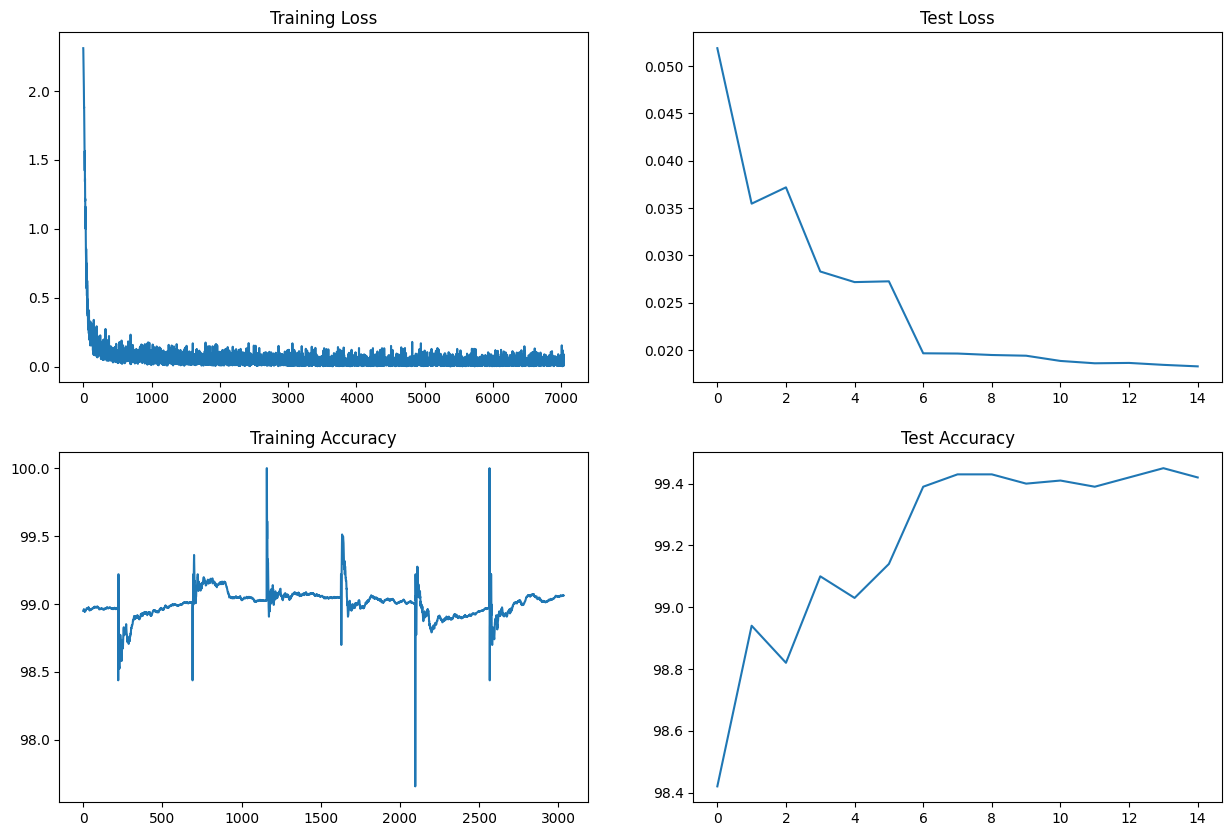

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")